# Execução do algoritimo de agrupamento DBSCAN

- #### Execução e Comparação do DBSCAN nos 4 Cenários

In [1]:
import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# 1. Carregar os Dados

In [2]:
base_path = 'datasets_tratados'
paths = {
    'Original': os.path.join(base_path, 'treino_original.pkl'),
    'SMOTE': os.path.join(base_path, 'treino_smote.pkl'),
    'Under': os.path.join(base_path, 'treino_under.pkl'),
    'Combine': os.path.join(base_path, 'treino_combine.pkl')
}

datasets = {}
for nome, path in paths.items():
    if os.path.exists(path):
        with open(path, mode='rb') as f:
            X, y = pickle.load(f)
            datasets[nome] = (X, y)

# 2. Loop DBSCAN


PROCESSANDO DBSCAN: Original
Dataset muito grande. Usando amostra de 30k para o DBSCAN...
Clusters encontrados: 1 | Pontos de Ruído: 772
-> AVISO: Não foi possível calcular silhueta (apenas 1 cluster ou só ruído).


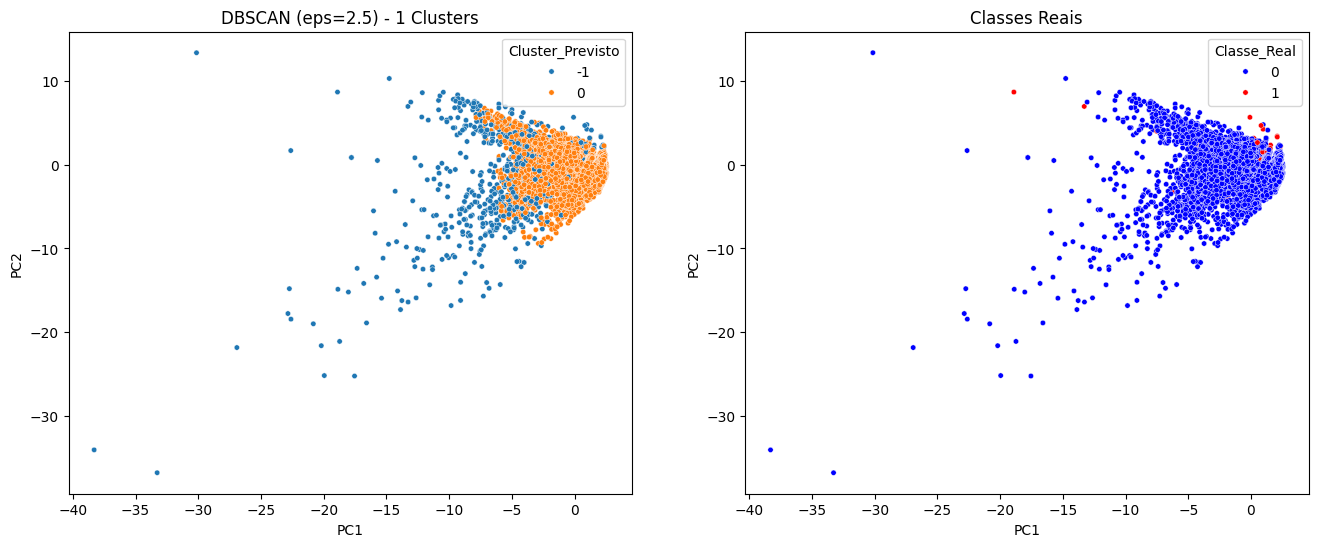


PROCESSANDO DBSCAN: SMOTE
Dataset muito grande. Usando amostra de 30k para o DBSCAN...
Clusters encontrados: 7 | Pontos de Ruído: 560
Calculando Silhouette Score...
-> Silhouette Score: 0.3031


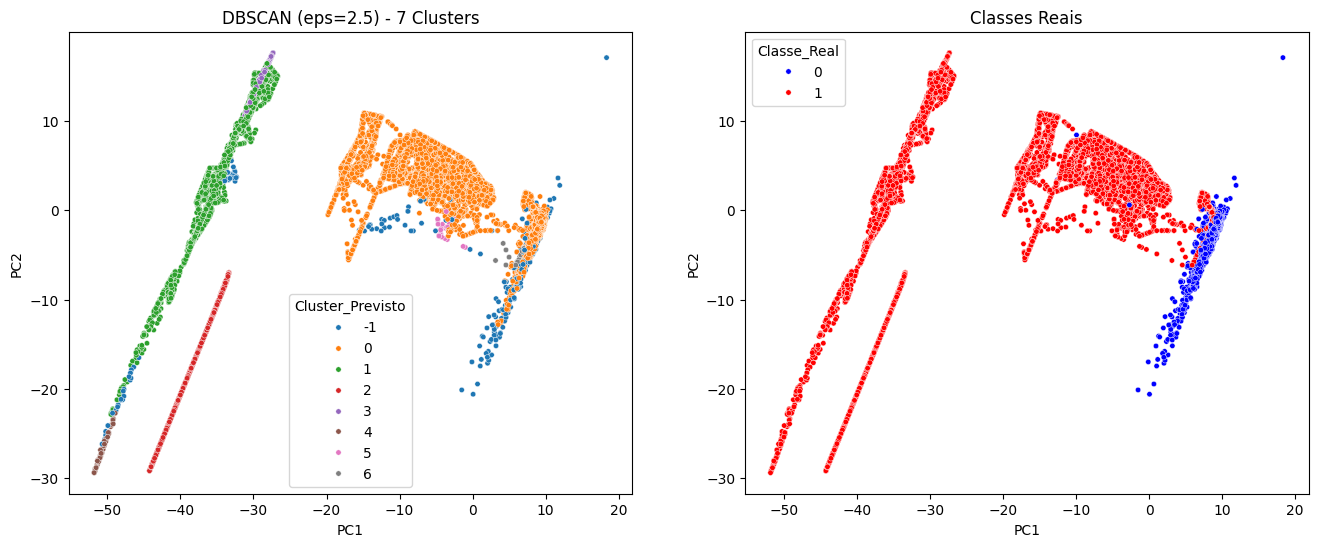


PROCESSANDO DBSCAN: Under
Clusters encontrados: 2 | Pontos de Ruído: 354
Calculando Silhouette Score...
-> Silhouette Score: 0.0902


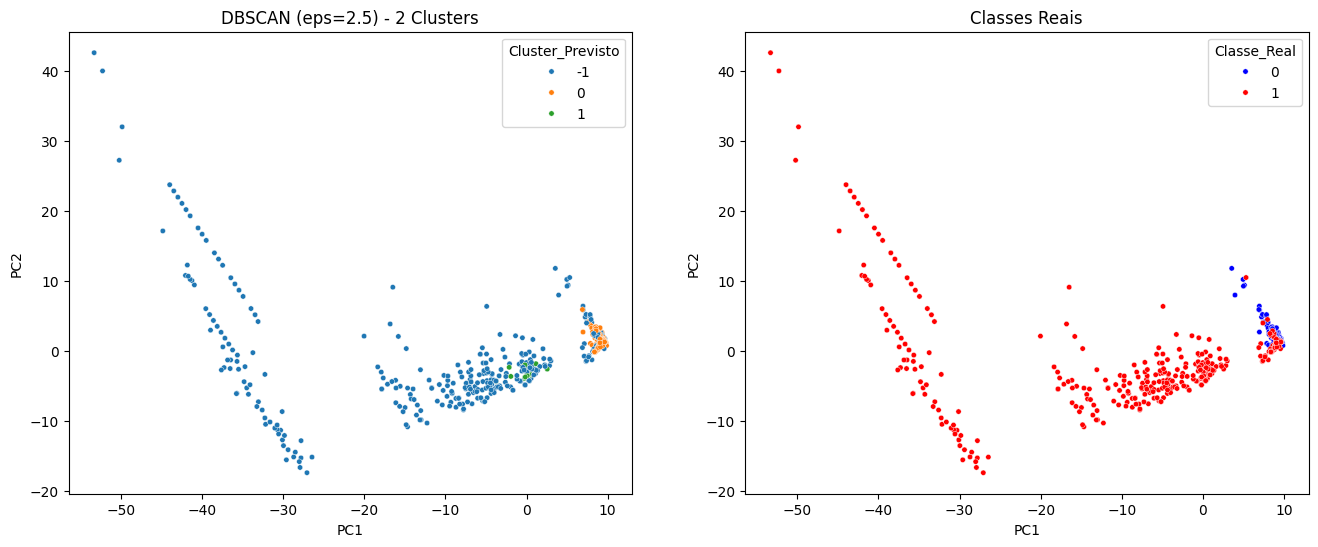


PROCESSANDO DBSCAN: Combine
Dataset muito grande. Usando amostra de 30k para o DBSCAN...
Clusters encontrados: 6 | Pontos de Ruído: 575
Calculando Silhouette Score...
-> Silhouette Score: 0.3714


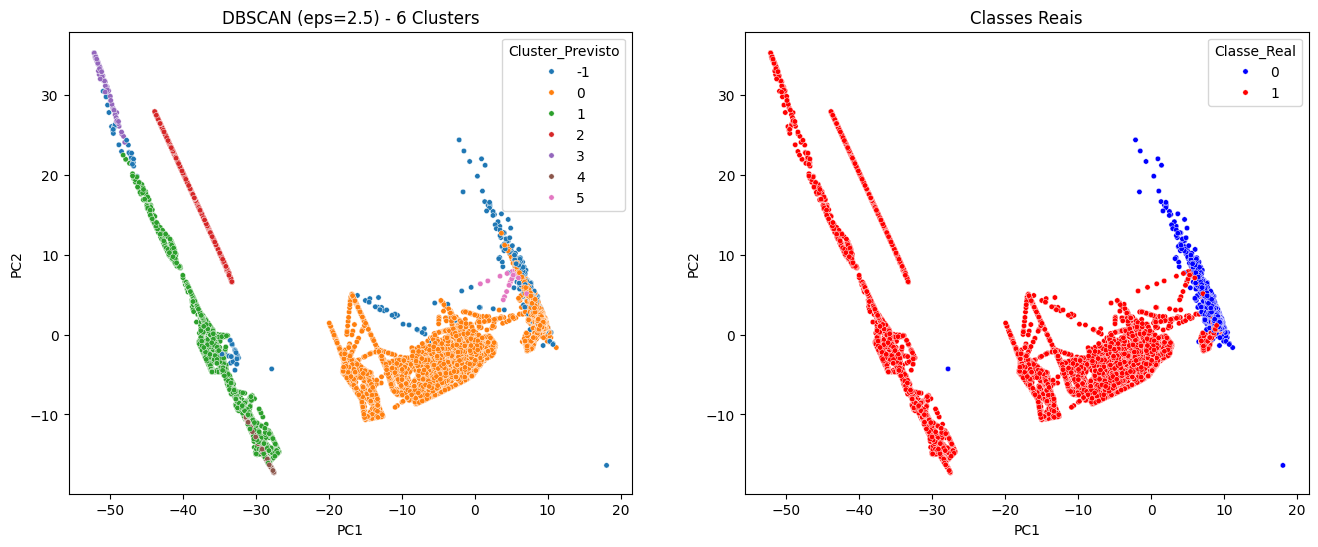

,Dataset,Silhouette,Clusters
0,Original,-1.000000,1
1,SMOTE,0.303063,7
2,Under,0.090223,2
3,Combine,0.371393,6


In [6]:
resultados_dbscan = []

for nome_dataset, (X_train, y_train) in datasets.items():
    print(f"\n{'='*60}")
    print(f"PROCESSANDO DBSCAN: {nome_dataset}")
    
    # IMPORTANTE: O eps define o raio de vizinhança. 
    # Em alta dimensionalidade (30 colunas), valores pequenos (< 1) costumam dar apenas ruído (-1).
    # Testaremos eps=2.5 e min_samples=5. Se der erro, ajuste o eps para cima.
    dbscan = DBSCAN(eps=5, min_samples=20)
    
    # Para datasets gigantes, o DBSCAN pode consumir muita memória. 
    # Usaremos uma amostra se for > 30k linhas para fins didáticos (remova o slicing para rodar full)
    if X_train.shape[0] > 30000:
        print("Dataset muito grande. Usando amostra de 30k para o DBSCAN...")
        indices = np.random.choice(X_train.shape[0], 30000, replace=False)
        X_run = X_train.iloc[indices] if hasattr(X_train, 'iloc') else X_train[indices]
        y_run = y_train.iloc[indices] if hasattr(y_train, 'iloc') else y_train[indices]
    else:
        X_run = X_train
        y_run = y_train

    # Treinamento
    labels = dbscan.fit_predict(X_run)
    
    # Verificação de Erro: O DBSCAN encontrou clusters ou só ruído?
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    print(f"Clusters encontrados: {n_clusters} | Pontos de Ruído: {n_noise}")

    # Cálculo da Silhueta (Só funciona se houver mais de 1 cluster real)
    score = -1 # Valor padrão ruim
    if n_clusters > 1:
        try:
            print("Calculando Silhouette Score...")
            score = silhouette_score(X_run, labels, sample_size=10000)
            print(f"-> Silhouette Score: {score:.4f}")
        except:
            print("Erro no cálculo da silhueta.")
    else:
        print("-> AVISO: Não foi possível calcular silhueta (apenas 1 cluster ou só ruído).")

    resultados_dbscan.append({'Dataset': nome_dataset, 'Silhouette': score, 'Clusters': n_clusters})

    # Visualização
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_run)
    
    df_viz = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
    df_viz['Cluster_Previsto'] = labels
    df_viz['Classe_Real'] = y_run.values if hasattr(y_run, 'values') else y_run

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    
    # Gráfico A: DBSCAN (Note que -1 é ruído/preto)
    sns.scatterplot(x='PC1', y='PC2', hue='Cluster_Previsto', data=df_viz, palette='tab10', s=15, ax=ax[0])
    ax[0].set_title(f'DBSCAN (eps=2.5) - {n_clusters} Clusters')
    
    # Gráfico B: Realidade
    sns.scatterplot(x='PC1', y='PC2', hue='Classe_Real', data=df_viz, palette={0:'blue', 1:'red'}, s=15, ax=ax[1])
    ax[1].set_title('Classes Reais')
    
    plt.show()

# Resumo Final
pd.DataFrame(resultados_dbscan)


--- RESUMO COMPARATIVO DE PERFORMANCE (K-Means k=2) ---
    Dataset  Silhouette  Clusters
3   Combine    0.371393         6
1     SMOTE    0.303063         7
2     Under    0.090223         2
0  Original   -1.000000         1


C:\Users\Cliente\AppData\Local\Temp\ipykernel_19072\1579935994.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Dataset', y='Silhouette', data=df_resultados, palette='magma')


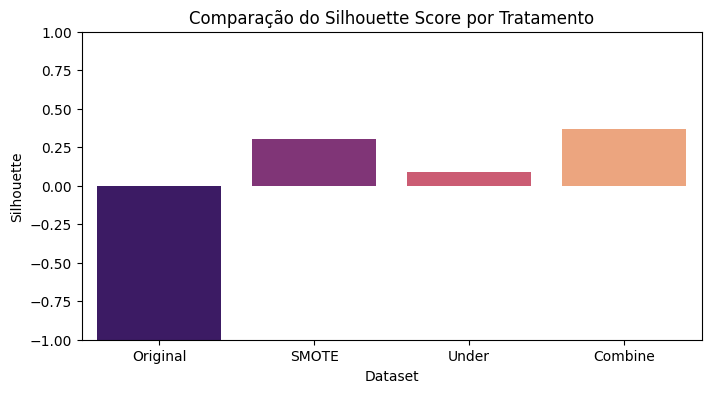

In [7]:
df_resultados = pd.DataFrame(resultados_dbscan)
print("\n--- RESUMO COMPARATIVO DE PERFORMANCE (K-Means k=2) ---")
print(df_resultados.sort_values(by='Silhouette', ascending=False))

# Plotagem do gráfico de barras das silhuetas
if not df_resultados.empty:
    plt.figure(figsize=(8, 4))
    sns.barplot(x='Dataset', y='Silhouette', data=df_resultados, palette='magma')
    plt.title('Comparação do Silhouette Score por Tratamento')
    plt.ylim(-1, 1) # Silhouette varia de -1 a 1
    plt.show()